In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
print(f"Torch: {torch.__version__}")

import gc

gc.collect()

torch.cuda.empty_cache()

# Training settings
batch_size = 16
epochs = 20
lr = 1e-5
gamma = 0.7
seed = 42



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda'


train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.3),
        transforms.RandomVerticalFlip(0.3),
        transforms.RandomRotation(120),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#归一化到[-1.0,1.0]
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)





Torch: 1.13.0+cu116


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

# test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
# training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/NEW_DATASET/TRAIN',
#                                                  target_size = (224, 224),
#                                                  batch_size = 32,
#                                                  class_mode = 'categorical')

# test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/NEW_DATASET/TEST',
#                                             target_size = (224, 224),
#                                             batch_size = 32,
#                                             class_mode = 'categorical')

In [6]:
import torch
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt

train_dir = '/content/drive/MyDrive/New_war/train'
val_dir = '/content/drive/MyDrive/New_war/val'
test_dir = '/content/drive/MyDrive/New_war/test'

train_img_data = torchvision.datasets.ImageFolder(train_dir,
                                            transform=train_transforms,
                                            )

val_img_data = torchvision.datasets.ImageFolder(val_dir,
                                            transform=val_transforms,
                                            )
test_img_data = torchvision.datasets.ImageFolder(test_dir,
                                            transform=test_transforms,
                                            )
 
train_data_loader = torch.utils.data.DataLoader(train_img_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_img_data, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_img_data, batch_size=batch_size, shuffle=True)



print(len(train_data_loader.dataset))
print(len(val_data_loader.dataset))
print(len(test_data_loader.dataset))


12584
2694
2696


In [7]:
!pip -q install timm
import timm
#torch.hub.list('pytorch/vision')
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
#model.fc.out_features = 12
#model.to(device)

import json
from PIL import Image
import torch
from torchvision import transforms

device = 'cuda'

model = timm.create_model('inception_v3', pretrained=True, num_classes=2).to(device)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.6 MB/s eta 0:00:00


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [15]:
torch.cuda.get_device_name(device=0)

'Tesla T4'

In [10]:
torch.cuda.is_available()

True

In [11]:
torch.cuda.device_count()

1

In [12]:
torch.cuda.current_device()

0

In [17]:



from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

model.train()
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    #for data, label in tqdm(train_loader):
    for data, label in tqdm(train_data_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_data_loader)
        epoch_loss += loss / len(train_data_loader)
        
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_data_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_data_loader)
            epoch_val_loss += val_loss / len(val_data_loader)
            
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    torch.save(model, './model_inception_v3.pt')  

  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6196 - acc: 0.7115 - val_loss : 0.5959 - val_acc: 0.7290



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.5481 - acc: 0.7545 - val_loss : 0.5574 - val_acc: 0.7326



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5218 - acc: 0.7626 - val_loss : 0.5143 - val_acc: 0.7585



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5089 - acc: 0.7702 - val_loss : 0.5255 - val_acc: 0.7522



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5043 - acc: 0.7713 - val_loss : 0.5132 - val_acc: 0.7754



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.4947 - acc: 0.7772 - val_loss : 0.4988 - val_acc: 0.7768



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4903 - acc: 0.7798 - val_loss : 0.4993 - val_acc: 0.7701



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4855 - acc: 0.7802 - val_loss : 0.4907 - val_acc: 0.7849



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.4831 - acc: 0.7776 - val_loss : 0.5003 - val_acc: 0.7777



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.4735 - acc: 0.7892 - val_loss : 0.4980 - val_acc: 0.7763



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.4714 - acc: 0.7880 - val_loss : 0.4925 - val_acc: 0.7717



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.4646 - acc: 0.7890 - val_loss : 0.4943 - val_acc: 0.7812



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.4621 - acc: 0.7904 - val_loss : 0.4885 - val_acc: 0.7806



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.4584 - acc: 0.7936 - val_loss : 0.4845 - val_acc: 0.7779



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.4521 - acc: 0.7992 - val_loss : 0.4834 - val_acc: 0.7841



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.4500 - acc: 0.7974 - val_loss : 0.4869 - val_acc: 0.7763



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.4432 - acc: 0.8007 - val_loss : 0.4908 - val_acc: 0.7878



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.4371 - acc: 0.8064 - val_loss : 0.4961 - val_acc: 0.7877



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.4320 - acc: 0.8065 - val_loss : 0.4877 - val_acc: 0.7793



  0%|          | 0/787 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.4302 - acc: 0.8089 - val_loss : 0.4981 - val_acc: 0.7747



In [18]:
model.eval()
prob_all = []
lable_all = []
prob_score=[]
i=0
for data, label in tqdm(test_data_loader):
        data = data.to(device)
        label = label.to(device)
        l2 = label.cpu().detach().numpy()
        lable_all.extend(l2)
        prob = model(data) 
        prob = prob.cpu().detach().numpy() 
        prob_score.extend(prob) 
        prob_all.extend(np.argmax(prob,axis=1)) 
        i=i+1
#print(prob_all)
#print(label_train)
print(i)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

target_names = ['Hate','No']

print("Accuracy:{:.4f}".format(accuracy_score(lable_all, prob_all) ))
print("Recall:{:.4f}".format(recall_score(lable_all, prob_all,average='macro') ))
print("Precision:{:.4f}".format(precision_score(lable_all, prob_all,average='macro') ))
print("f1_score:{:.4f}".format(f1_score(lable_all, prob_all,average='macro') ))
print(classification_report(lable_all,prob_all,target_names=target_names,digits=4))

#fpr, tpr, thresholds = roc_curve(lable_all, prob_score, pos_label=2)
#print("Auc:{:.4f}".format(roc_auc_score(lable_all, prob_score,average='macro') ))
print(confusion_matrix(prob_all,lable_all))

  0%|          | 0/169 [00:00<?, ?it/s]

169
Accuracy:0.7800
Recall:0.6290
Precision:0.6856
f1_score:0.6439
              precision    recall  f1-score   support

        Hate     0.5519    0.3438    0.4237       634
          No     0.8192    0.9142    0.8641      2062

    accuracy                         0.7800      2696
   macro avg     0.6856    0.6290    0.6439      2696
weighted avg     0.7563    0.7800    0.7605      2696

[[ 218  177]
 [ 416 1885]]


[Text(0.5, 0, 'Hate (1)'), Text(1.5, 0, 'No (1)')]

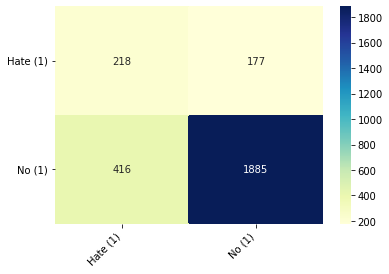

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_mat=confusion_matrix(prob_all,lable_all)
class_label=train_img_data.classes
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
df_cm
#conf_mat
heatmap=sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45, ha='right')

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, sampler, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for data, label in tqdm(iterator):
            data = data.to(device)
            #label = label.to(device)
            l2 = label.cpu().detach().numpy()
            lable_all.extend(l2)
            prob = model(data) #表示模型的预测输出
            outputs.append(prob.cpu())
            labels.append(label)
        

    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

outputs, labels = get_representations(model, train_data_loader)


  0%|          | 0/787 [00:00<?, ?it/s]

In [21]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [22]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

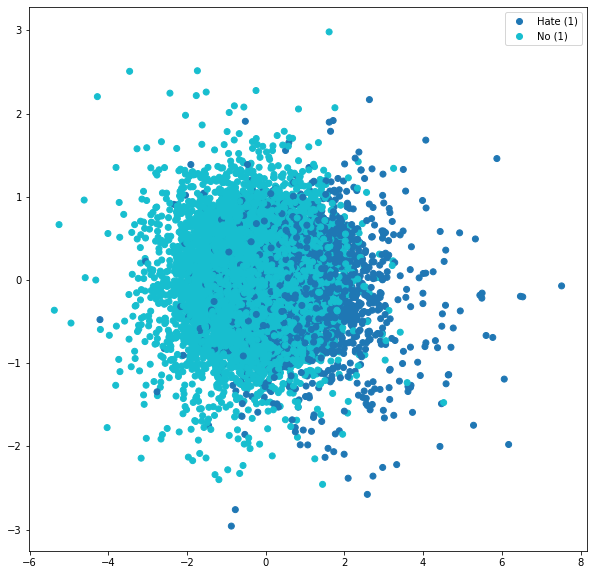

In [23]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, train_img_data.classes)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


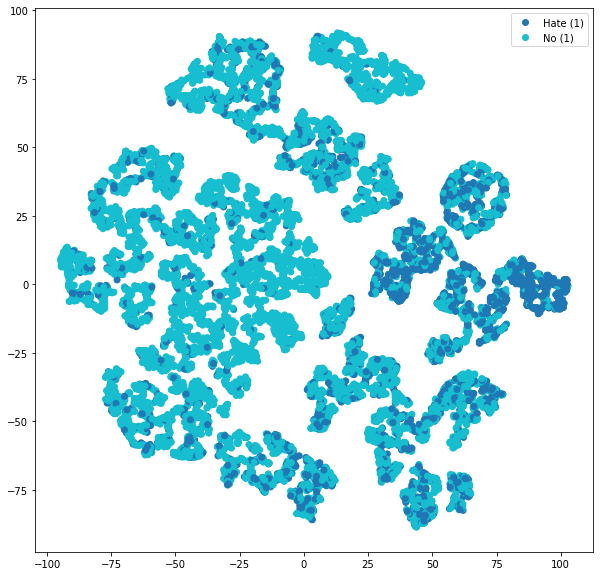

In [24]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, early_exaggeration=3, random_state = 8, perplexity=35,learning_rate=300)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, train_img_data.classes)

In [25]:
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:]

(770,
 ['adv_inception_v3',
  'bat_resnext26ts',
  'beit_base_patch16_224',
  'beit_base_patch16_224_in22k',
  'beit_base_patch16_384',
  'beit_large_patch16_224',
  'beit_large_patch16_224_in22k',
  'beit_large_patch16_384',
  'beit_large_patch16_512',
  'beitv2_base_patch16_224',
  'beitv2_base_patch16_224_in22k',
  'beitv2_large_patch16_224',
  'beitv2_large_patch16_224_in22k',
  'botnet26t_256',
  'cait_m36_384',
  'cait_m48_448',
  'cait_s24_224',
  'cait_s24_384',
  'cait_s36_384',
  'cait_xs24_384',
  'cait_xxs24_224',
  'cait_xxs24_384',
  'cait_xxs36_224',
  'cait_xxs36_384',
  'coat_lite_mini',
  'coat_lite_small',
  'coat_lite_tiny',
  'coat_mini',
  'coat_tiny',
  'coatnet_0_rw_224',
  'coatnet_1_rw_224',
  'coatnet_bn_0_rw_224',
  'coatnet_nano_rw_224',
  'coatnet_rmlp_1_rw_224',
  'coatnet_rmlp_2_rw_224',
  'coatnet_rmlp_nano_rw_224',
  'coatnext_nano_rw_224',
  'convit_base',
  'convit_small',
  'convit_tiny',
  'convmixer_768_32',
  'convmixer_1024_20_ks9_p14',
  'convm